In [1]:
import numpy as np
import lysis
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FFMpegWriter, FuncAnimation
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.patches import Patch

from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"

In [2]:
e = lysis.util.Experiment(os.path.join("..", "..", "data"), experiment_code="2023-01-18-1600")
e.read_file()
rng = np.random.default_rng()
file_code = ".f-array.dat"

In [3]:
print(e)

experiment_code : 2023-01-18-1600
data_filenames  : unbinding_time    : tsectPA.dat
                  lysis_time        : lysismat.dat
                  total_lyses       : lenlysisvect.dat
                  degradation_state : deg.dat
micro_params    : None
macro_params    : binding_rate       : 0.1
                  pore_size          : 0.00010135
                  diffusion_coeff    : 5e-07
                  binding_sites      : 427
                  forced_unbind      : 0.0852
                  average_bind_time  : 27.8
                  grid_node_distance : 1.0862
                  cols               : 93
                  rows               : 121
                  full_row           : 278
                  xz_row             : 185
                  total_edges        : 33,545
                  total_fibers       : 25,761
                  empty_rows         : 28
                  last_empty_edge    : 7,783
                  total_molecules    : 43,074
                  moving_pro

In [4]:
deg = np.fromfile(os.path.join(e.os_path, "deg" + file_code))
mol_location = np.fromfile(os.path.join(e.os_path, "m_loc" + file_code), dtype=np.int32)
mol_status = np.fromfile(os.path.join(e.os_path, "m_bound" + file_code), dtype=np.int32)
tsave = np.fromfile(os.path.join(e.os_path, "tsave" + file_code))

In [5]:
deg = deg.reshape(e.macro_params.total_trials, e.macro_params.number_of_saves, e.macro_params.total_edges)
mol_location = mol_location.reshape(e.macro_params.total_trials, e.macro_params.number_of_saves, e.macro_params.total_molecules)
mol_status = mol_status.reshape(e.macro_params.total_trials, e.macro_params.number_of_saves, e.macro_params.total_molecules)
tsave = tsave.reshape(e.macro_params.total_trials, e.macro_params.number_of_saves)

In [6]:
mol_status = mol_status.astype(np.bool_)

In [7]:
mapped_deg = -deg
mapped_deg[deg == 0] = e.macro_params.total_time * 2
mapped_deg[deg == -1] = 0

In [8]:
def plot_coords(i, j):
    x = j
    y = i
    if j % 3 == 0:
        return x / 3.0, y + 0.5
    if j % 3 == 1:
        return (x - 1) / 3.0, y
    if j % 3 == 2:
        return (x - 2) / 3.0 + 0.5, y

In [9]:
edge_index = np.empty(e.macro_params.total_edges, dtype=tuple)
for k in range(e.macro_params.total_edges):
    edge_index[k] = lysis.from_fortran_edge_index(k, e.macro_params.rows, e.macro_params.cols)

In [10]:
x_f = np.empty(e.macro_params.total_edges, dtype=float)
y_f = np.empty(e.macro_params.total_edges, dtype=float)
for k in range(e.macro_params.total_edges):
    i, j = edge_index[k]
    x_f[k], y_f[k] = plot_coords(i, j)

In [11]:
colormap_f = plt.cm.cividis(np.arange(plt.cm.cividis.N))
colormap_f[:,3] = 0.3
colormap_f = ListedColormap(colormap_f)

#colormap = mpl.colormaps['viridis']
#colormap[:,0:3] *= 0.5
colormap_f.set_extremes(bad='k', under='w', over='k')

In [12]:
d_x = (rng.random(size=e.macro_params.total_molecules) - 0.5) / 2.5
d_y = (rng.random(size=e.macro_params.total_molecules) - 0.5) / 2.5
x_m = np.empty((e.macro_params.total_trials, e.macro_params.number_of_saves, e.macro_params.total_molecules), dtype=float)
y_m = np.empty((e.macro_params.total_trials, e.macro_params.number_of_saves, e.macro_params.total_molecules), dtype=float)
for run in range(e.macro_params.total_trials):
    for t in range(e.macro_params.number_of_saves):
        for k in range(e.macro_params.total_molecules):
            i, j = edge_index[mol_location[run, t, k]-1]
            x_m[run, t, k], y_m[run, t, k] = plot_coords(i, j)
        x_m[run, t] += d_x
        y_m[run, t] += d_y

In [13]:
colormap_m = ListedColormap(['green', 'red'])
bounds=[0,.5,1]
norm_m = BoundaryNorm(bounds, colormap_m.N)

In [14]:
run = 0

fig = plt.figure(figsize=(121, 121), dpi=10)
ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()
vmin = 0
vmax = e.macro_params.cols - 1

ydiff = e.macro_params.rows - e.macro_params.cols

ax.set_xlim(vmin - 0.25, vmax + 0.25)
ax.set_ylim(vmin - 0.25, vmax + ydiff + 0.25)
ax.set_aspect('equal')
fig.canvas.draw()
title = ax.annotate(f"t = {tsave[run, 0]:.1f} sec", (0, 0), zorder=100)
s = ((ax.get_window_extent().width  / (vmax-vmin+0.5) * 72/(2*fig.dpi)) ** 2)
scatt_f = ax.scatter(x_f, y_f, 
                     s=s, marker='s', linewidths=0,
                     c=mapped_deg[run, 0], cmap=colormap_f, 
                     vmin=1, 
                     vmax=mapped_deg[run, 
                                     e.macro_params.number_of_saves-1
                                    ][mapped_deg[run, 
                                                 e.macro_params.number_of_saves-1
                                                ] < e.macro_params.total_time
                                     ].max())
scatt_m = ax.scatter(x_m[run, 0], y_m[run, 0], 
                     s=s/2.5, marker='o', linewidths=0,
                     c=mol_status[run, 0], cmap=colormap_m, norm=norm_m
                     )

def update(frame_number):
    scatt_f.set_array(mapped_deg[run, frame_number])
    scatt_m.set_array(mol_status[run, frame_number])
    scatt_m.set_offsets(np.append((x_m[run, frame_number],), (y_m[run, frame_number],), axis=0).T)
    title.set_text(f"t = {tsave[run, frame_number]:.1f} sec")
    
animation = FuncAnimation(fig, update, frames=np.arange(e.macro_params.number_of_saves), interval=200)

FFwriter = FFMpegWriter(fps=10)
animation.save(os.path.join(e.os_path, "degrade_animation" + file_code[:-4] + ".mp4"), writer = FFwriter)
plt.close()

#HTML(animation.to_jshtml())
#HTML(animation.to_html5_video())

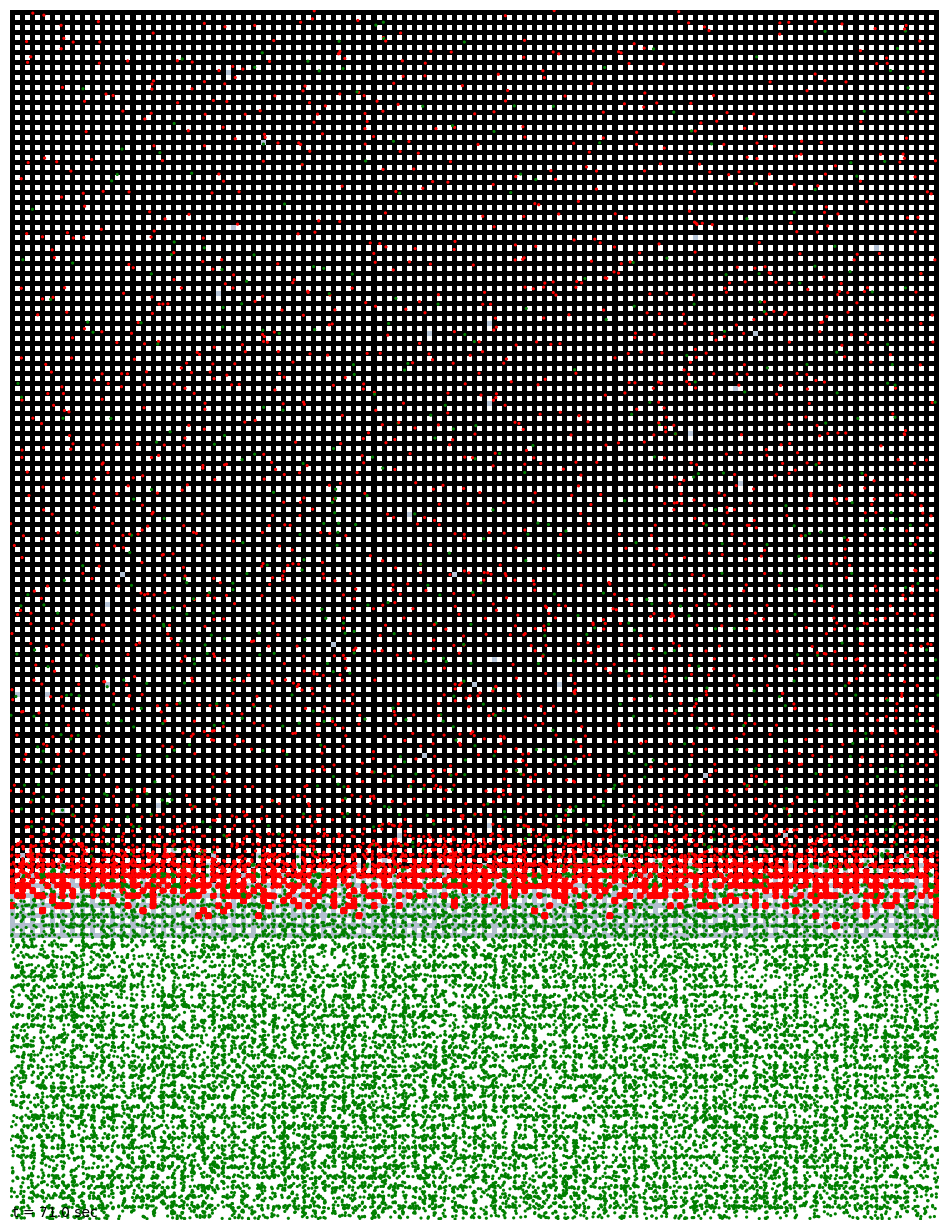

In [15]:
run = 0
time = 70

frame = int(np.argwhere(tsave[0] >= time)[0])

fig = plt.figure(figsize=(12.1, 12.1), dpi=100)
ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()
vmin = 0
vmax = e.macro_params.cols - 1

ydiff = e.macro_params.rows - e.macro_params.cols

ax.set_xlim(vmin - 0.25, vmax + 0.25)
ax.set_ylim(vmin - 0.25, vmax + ydiff + 0.25)
ax.set_aspect('equal')
fig.canvas.draw()
title = ax.annotate(f"t = {tsave[run, frame]:.1f} sec", (0, 0), zorder=100)
s = ((ax.get_window_extent().width  / (vmax-vmin+0.5) * 72/(2*fig.dpi)) ** 2)
scatt_f = ax.scatter(x_f, y_f, 
                     s=s, marker='s', linewidths=0,
                     c=mapped_deg[run, frame], cmap=colormap_f, 
                     vmin=1, 
                     vmax=mapped_deg[run, 
                                     e.macro_params.number_of_saves-1
                                    ][mapped_deg[run, 
                                                 e.macro_params.number_of_saves-1
                                                ] < e.macro_params.total_time
                                     ].max())
scatt_m = ax.scatter(x_m[run, frame], y_m[run, frame], 
                     s=s/2.5, marker='o', linewidths=0,
                     c=mol_status[run, frame], cmap=colormap_m, norm=norm_m
                     )

#fig.legend([Patch(color=colormap_m(b)) for b in [0.2, 0.8]], ["Unbound tPA", "Bound tPA"])
        
fig.show()